In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# ATLANTIC region

In [2]:
import xarray as xr
import os as os
import pandas as pd
import scipy.stats as stats
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.fft import fft, fftfreq
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

# Assuming you have already computed and stored your clusters in the 'clusters' variable

# Convert clusters to a list of arrays (one array per cluster)
from sklearn.metrics import silhouette_score, pairwise_distances
import minisom

def einlesen(area, nc):
    if area=="ATLANTIC":
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc
    
        lat = nc.variables['lat'][:54]
        lon = nc.variables['lon'][:]
        reduced_lon = lon[:80]
        lon = np.concatenate((reduced_lon, lon[-80:]), axis=0)
        time = nc.variables['time'][:]
        var = nc.variables['MSL'][:] # zonal wind
        reduced_var = var[:, :54, :80]
        var = np.concatenate((reduced_var, var[:, :54, -80:]), axis=2)
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var
    elif area=="ARCTIC":
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=60, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc

        lat = nc.variables['lat'][:28]
        lon = nc.variables['lon'][:]

        time = nc.variables['time'][:]
        var = nc.variables['MSL'][:] # zonal wind
        var = var[:, :28, :]
        lr = LR  # Learning rate
        sigma = SIGMA  # Sigma parameter
        num_iter = NUM_ITER  # Number of iterations
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var

        
        
def clustering(LR, SIGMA, THRESHOLD,NUM_ITER, AREA, data_normalized, lon, lat, var,a,b, TRAINING, PLOTTEN):
    area=AREA #ATLANTIC
    method="analysis" #analysis
    number_cluster_soms=a*b
    if area=="ATLANTIC":
        print("First Training taking place")
        # Initialize the SOM
        #num_iter = NUM_ITER
        lr = LR[0]
        sigma = SIGMA[0]
        def updated_lr(lr,epoch,num_iter):
            return lr
        def updated_sigma(sigma,epoch, num_iter):
            return sigma
        
        som = minisom.MiniSom(a, b, data_normalized.shape[1], sigma=sigma, learning_rate=lr, neighborhood_function="gaussian")
        
        # Initialize weights randomly
        som.random_weights_init(data_normalized)
    
        # Store initial weights
        initial_weights = np.copy(som.get_weights())
        if TRAINING=="number":
            num_iter = NUM_ITER[0]
            losses = []

            # Store initial weights
            initial_weights = np.copy(som.get_weights())
            
            # Training loop
            for epoch in range(num_iter):
                # Train the SOM for one epoch
                som.train(data_normalized, num_iteration=1)
                #for d_ci computation -> sigma update
                som.sigma=updated_sigma(sigma,epoch,num_iter)
                som.learning_rate=updated_lr(lr,epoch,num_iter)
                  
                # Calculate the Euclidean distance between initial and updated weights for each neuron
                weight_changes = np.linalg.norm(initial_weights - som.get_weights(), axis=-1)
                
                # Calculate the loss as the sum of all weight changes
                loss = np.sum(weight_changes)
                losses.append(loss)
            print(f"Number of epochs is {num_iter}")
            # Plot the losses
            plt.figure(figsize=(10, 6))
            plt.plot(range(num_iter), losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('SOM Loss Over Epochs')
            plt.show()
            num_epochs=num_iter
            print("Second Training taking place")
            
            lr = LR[1]
            sigma = SIGMA[1]
            som.learning_rate=lr
            som.sigma=sigma
            num_iter=NUM_ITER[1]
            for epoch in range(num_iter):
                # Train the SOM for one epoch
        
                som.train(data_normalized, num_iteration=1)
                som.sigma=updated_sigma(sigma,epoch,num_iter)
                som.learning_rate=updated_lr(lr,epoch,num_iter)
                
                # Calculate the Euclidean distance between initial and updated weights for each neuron
                weight_changes = np.linalg.norm(initial_weights - som.get_weights(), axis=-1)
                
                # Calculate the loss as the sum of all weight changes
                loss = np.sum(weight_changes)
                losses.append(loss)
            print(f"Number of epochs is {NUM_ITER[0]+NUM_ITER[1]}")
            # Plot the losses
            plt.figure(figsize=(10, 6))
            plt.plot(range(NUM_ITER[0]+NUM_ITER[1]), losses)
            #plt.ylim(max(losses)-1e-7,max(losses)+1e-7)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('SOM Loss Over Epochs')
            plt.show()
            num_epochs=num_iter
        # Training loop
        elif TRAINING=="threshold":
            num_epochs = 0  # You can adjust the number of epochs
            losses = [0] 
            # Train the SOM
            threshold=THRESHOLD
            
            som.train_random(data_normalized, num_iteration=1)

            # Calculate the Euclidean distance between initial and updated weights for each neuron
            weight_changes = np.linalg.norm(initial_weights - som.get_weights())

            # Calculate the loss as the sum of all weight changes
            loss = np.sum(weight_changes)
            losses.append(loss)
            num_epochs+=1
            while np.abs(losses[num_epochs-1]-losses[num_epochs-2]) > threshold:
                # Train the SOM for one epoch
                #som.learning_rate = learning_rate_decay(lr, num_epochs)
                #som.sigma = sigma_decay(sigma, num_epochs)
                som.train_random(data_normalized, num_iteration=1)

                # Calculate the Euclidean distance between initial and updated weights for each neuron
                weight_changes = np.linalg.norm(initial_weights - som.get_weights())

                # Calculate the loss as the sum of all weight changes
                loss = np.sum(weight_changes)
                #print(loss)
                losses.append(loss)
                num_epochs+=1

            print(f"Number of epochs is {num_epochs}")
            # Plot the losses
            plt.figure(figsize=(10, 6))
            plt.plot(np.linspace(0,num_epochs,num_epochs+1), losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('SOM Loss Over Epochs')
            plt.show()
        print("clustering findet statt")
        # Find the best-matching unit (BMU) for each data point
        bmus = np.array([som.winner(d) for d in data_normalized])

        # Create a dictionary to map BMUs to data points
        bmu_to_data = {}
        for i, bmu in enumerate(bmus):
            bmu_tuple = tuple(bmu)  # Convert NumPy array to tuple
            if bmu_tuple not in bmu_to_data:
                bmu_to_data[bmu_tuple] = []
            bmu_to_data[bmu_tuple].append(i)

        # Convert the dictionary values (lists of data indices) to clusters
        clusters = list(bmu_to_data.values())

        # Print cluster sizes
        sizes = [len(cluster) for cluster in clusters]
        for i, cluster_size in enumerate(sizes):
            normalized_size = cluster_size / 5520
            print(f"Cluster {i}: Size {normalized_size:.4f}")
        difference = max(sizes) - min(sizes)
        print(difference)
        print("SOMS fertig")
        
        if method=="analysis":

            summary = np.empty((0, 2), dtype=int)
            import time 

            # Loop through each array and build the summary
            clusters_to_process = [clusters[i] for i in range(number_cluster_soms)]  # This covers clusters[0] to clusters[8]

            # Initialize the 'summary' array
            summary = np.empty((0, 2), dtype=int)

            # Loop through the selected clusters
            for idx, arr in enumerate(clusters_to_process):
                arr_summary = np.vstack((arr, np.full_like(arr, idx)))
                summary = np.vstack((summary, arr_summary.T))

            # Sort the summary array based on the first column (numbers)
            sorted_summary = summary[summary[:, 0].argsort()]

            np.savetxt(path+f"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt", sorted_summary)
            datesfile=path+f"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_{number_cluster_soms}tabcluster_10tabPC_dates.txt"
        
            dates=np.loadtxt(datesfile)
            cluster=dates[:5520,1] # weil auch zukunft in dem ding drin ist
            cluster_numbers = np.linspace(0,number_cluster_soms-1,number_cluster_soms)
            iteration=0
            while PLOTTEN and iteration==0:
                print("PLOTTEN findet statt")
                FONTSIZE = 18
                lons,lats = np.meshgrid(lon,lat)
                # Loop through the cluster numbers
                num_rows = a
                num_cols = b
                # Create a single figure to contain all the plots
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 15))  # Adjust figsize as needed

                # Loop through the cluster numbers
                for i, cluster_number in enumerate(cluster_numbers):
                    map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
                    x,y = map(lons,lats)
                    nc = NetCDFFile(path + path_file)
                    # Create a filter for the current cluster number
                    cluster_filter = [x == cluster_number for x in cluster]
                    FONTSIZE = 18
                    # Calculate the mean for the current cluster
                    soms = np.mean(var[cluster_filter, :, :], axis=0)

                    # Define levels and boundaries
                    levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
                    boundaries = np.linspace(-0, 0.1, 13)
                    
                    row_index = i // num_cols  # Integer division to determine row
                    col_index = i % num_cols 
                    print(row_index, col_index)
                    # Create the contour plot in the corresponding subplot
                    # Create the contour plot in the corresponding subplot
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    variable = map.contourf(x, y, soms[:54, :], cmap="seismic", levels=levels, zorder=5, extend='both', ax=ax)
                    cb = map.colorbar(variable, ax=ax, fraction=0.05, pad=0.08, ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

                    # Customize the colorbar
                    for t in cb.ax.get_xticklabels():
                        t.set_fontsize(18)
                    cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

                    # Customize the plot title and labels
                    if num_rows > 1:
                        axes[row_index, col_index].set_title(f'SOMS Cluster {cluster_number}')
                    else:
                        axes[col_index].set_title(f'SOMS Cluster {cluster_number}')
                    cb.set_label('slp [hPa]', fontsize=18)

                    # Draw coastlines and countries
                    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
                    map.drawcoastlines(linewidth=0.3, zorder=6, ax=ax)
                    map.drawcountries(linewidth=0.1, zorder=7, ax=ax)
                for i in range(len(cluster_numbers), num_rows * num_cols):
                    if num_rows > 1:
                        fig.delaxes(axes[i // num_cols, i % num_cols])
                    else:
                        fig.delaxes(axes[i])
                # Adjust spacing between subplots
                plt.tight_layout()

                # Save the figure
                plt.savefig(f'N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/AREA.-90_90_89.7849_29.0866/CLUSTER/PLOTS/SOMS_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{LR}LR_{SIGMA}Sigma_{num_epochs}Epochs.png', dpi=300)

                # Display the plot (optional)
                plt.show()
                iteration+=1
        else:
            print("pl")
    elif area=="ARCTIC":
        print("ok")
    
    pairwise_distances_matrix = pairwise_distances(data_normalized)
    cluster_arrays = [data_normalized[cluster] for cluster in clusters]
    # Calculate Silhouette Score using BMUs as cluster labels
    silhouette_avg = silhouette_score(pairwise_distances_matrix, bmus.argmin(axis=1))
    print(f"Silhouette Score: {silhouette_avg}")


    # Calculate Dunn Index
    def dunn_index(cluster_arrays):
        min_intercluster_distances = float('inf')
        max_intracluster_diameter = 0.0

        for cluster1 in cluster_arrays:
            for cluster2 in cluster_arrays:
                if cluster1 is not cluster2:
                    # Calculate the minimum inter-cluster distance
                    intercluster_distance = pairwise_distances(cluster1, cluster2, metric='euclidean').min()
                    if intercluster_distance < min_intercluster_distances:
                        min_intercluster_distances = intercluster_distance

            # Calculate the maximum intra-cluster diameter
            intracluster_diameter = euclidean(cluster1.max(axis=0), cluster1.min(axis=0))
            if intracluster_diameter > max_intracluster_diameter:
                max_intracluster_diameter = intracluster_diameter

        return min_intercluster_distances / max_intracluster_diameter

    dunn = dunn_index(cluster_arrays)
    print(f"Dunn Index: {dunn}")
    print(np.array([silhouette_avg, dunn]))
    return silhouette_avg, dunn, bmus

<ipython-input-2-3a56a9059c8b>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:54]
<ipython-input-2-3a56a9059c8b>:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = nc.variables['lon'][:]
<ipython-input-2-3a56a9059c8b>:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this w

einlesen fertig
First Training taking place
Number of epochs is 5000


<Figure size 576x576 with 0 Axes>

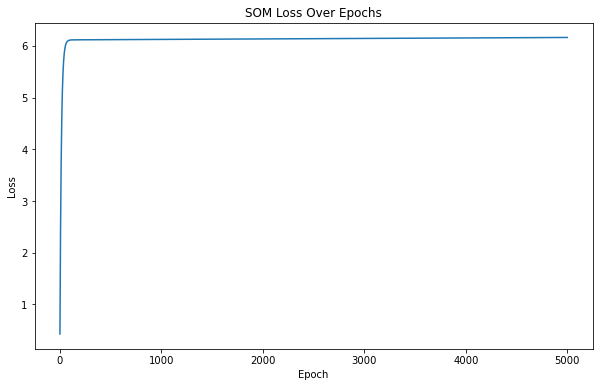

Second Training taking place
Number of epochs is 10000


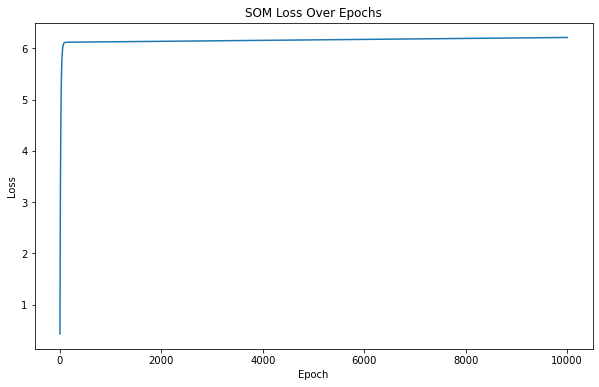

clustering findet statt
Cluster 0: Size 0.0042
Cluster 1: Size 0.0034
Cluster 2: Size 0.0161
Cluster 3: Size 0.0074
Cluster 4: Size 0.0315
Cluster 5: Size 0.0096
Cluster 6: Size 0.0069
Cluster 7: Size 0.0216
Cluster 8: Size 0.0181
Cluster 9: Size 0.0049
Cluster 10: Size 0.0085
Cluster 11: Size 0.0132
Cluster 12: Size 0.0399
Cluster 13: Size 0.0150
Cluster 14: Size 0.0107
Cluster 15: Size 0.0143
Cluster 16: Size 0.0435
Cluster 17: Size 0.0043
Cluster 18: Size 0.0043
Cluster 19: Size 0.0152
Cluster 20: Size 0.0402
Cluster 21: Size 0.0482
Cluster 22: Size 0.0190
Cluster 23: Size 0.0080
Cluster 24: Size 0.0339
Cluster 25: Size 0.0225
Cluster 26: Size 0.0101
Cluster 27: Size 0.0217
Cluster 28: Size 0.0103
Cluster 29: Size 0.0138
Cluster 30: Size 0.0107
Cluster 31: Size 0.0045
Cluster 32: Size 0.0208
Cluster 33: Size 0.0047
Cluster 34: Size 0.0034
Cluster 35: Size 0.0127
Cluster 36: Size 0.0165
Cluster 37: Size 0.0027
Cluster 38: Size 0.0098
Cluster 39: Size 0.0181
Cluster 40: Size 0.0264
Cl

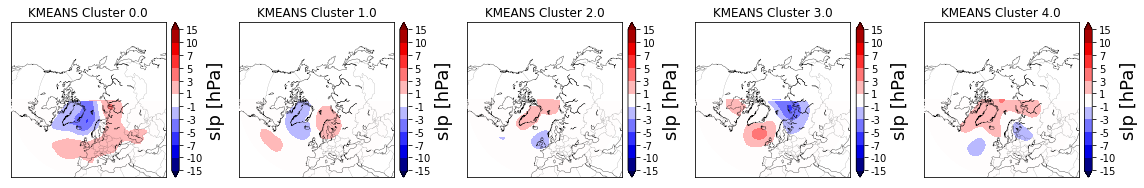

In [19]:
LR=np.array([0.07,1e-4])
SIGMA=np.array([0.2,0.01])
THRESHOLD=1e-7
NUM_ITER=np.array([5000,5000])
dunn=np.zeros(len(SIGMA))
silhouette=np.zeros(len(SIGMA))
AREA="ATLANTIC"
path = r"N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/"
path_file = r"slp_hpa_ERA5_1985-2014.N_mjjaso_atrbg_aacrm21_remapbnds.nc"

nc = NetCDFFile(path+path_file)
data_normalized, lon, lat, var = einlesen(AREA, nc)


silhouette, dunn, bmus = clustering(LR,SIGMA,THRESHOLD,NUM_ITER,AREA,data_normalized, lon, lat,var,10,10,TRAINING="number",PLOTTEN=False)
print(f"Der Silhouette score ist: {silhouette}")
print(f"Der Dunn-score ist: {dunn}")
# plt.plot(SIGMA,dunn)
# plt.savefig(f"N:/atm_glomod/user/jomuel001/Dokumente/Presentations/ARBEIT/Dunn_score.png")
# plt.show()
# plt.plot(SIGMA,silhouette)
# plt.savefig(f"N:/atm_glomod/user/jomuel001/Dokumente/Presentations/ARBEIT/Silhouette_score.png")
# plt.show()
# Assuming 'bmus' is your list of BMUs
Kmeans(bmus)

array([[2, 0],
       [2, 0],
       [0, 0],
       ...,
       [2, 1],
       [2, 1],
       [2, 1]], dtype=int64)

In [3]:
from sklearn.cluster import KMeans
from collections import Counter

def Kmeans(bmus):
    # Assuming 'bmus' is your list of BMUs
    num_clusters = 5  # Number of clusters

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(bmus)

    # Get the cluster labels assigned by K-means
    kmeans_labels = kmeans.labels_
    np.savetxt(path+r"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSKMEANSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10tabPC_dates.txt", kmeans_labels)
    datesfile=path+r"AREA.-90_90_89.7849_29.0866/CLUSTER/SOMSKMEANSslp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10tabPC_dates.txt"
    FONTSIZE = 18
    lons,lats = np.meshgrid(lon,lat)
    dates=np.loadtxt(datesfile)
    cluster=dates[:5520] # weil auch zukunft in dem ding drin ist
    cluster_numbers = [0.0, 1.0, 2.0, 3.0, 4.0]
    iteration=0
    fig, axes = plt.subplots(1, len(cluster_numbers), figsize=(16, 4))  # Adjust figsize as needed
    # Assuming kmeans_labels contains the cluster assignments
    cluster_counts = Counter(kmeans_labels)

    # Print the frequency of occurrence for each cluster
    for cluster_num, count in cluster_counts.items():
        print(f'Cluster {cluster_num}: Frequency = {count/5520}')
    # Loop through the cluster numbers
    for i, cluster_number in enumerate(cluster_numbers):
        map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        x,y = map(lons,lats)
        nc = NetCDFFile(path + path_file)
        # Create a filter for the current cluster number
        cluster_filter = [x == cluster_number for x in cluster]
        FONTSIZE = 18
        # Calculate the mean for the current cluster
        soms = np.mean(var[cluster_filter, :, :], axis=0)

        # Define levels and boundaries
        levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
        boundaries = np.linspace(-0, 0.1, 13)

        # Create the contour plot in the corresponding subplot
        variable = map.contourf(x, y, soms[:54, :], cmap="seismic", levels=levels, zorder=5, extend='both', ax=axes[i])
        cb = map.colorbar(variable, ax=axes[i],fraction=0.05, pad=0.08,
                          ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

        # Customize the colorbar
        for t in cb.ax.get_xticklabels():
            t.set_fontsize(18)
        cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

        # Customize the plot title and labels
        axes[i].set_title(f'KMEANS Cluster {cluster_number}')
        cb.set_label('slp [hPa]', fontsize=18)

        # Draw coastlines and countries
        map.drawcoastlines(linewidth=0.3, zorder=6, ax=axes[i])
        map.drawcountries(linewidth=0.1, zorder=7, ax=axes[i])

    # Adjust spacing between subplots
    plt.tight_layout()
    # Save the figure

    # Save the figure for the current cluster
    plt.savefig(f'N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/AREA.-90_90_89.7849_29.0866/CLUSTER/PLOTS/SOMSKMEANS_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{LR}LR_{SIGMA}Sigma.png', dpi=300)
